In [1]:
# Mount to Google drive
from google.colab import drive
drive.mount('/content/drive/')

# Navigate to necessary folder
%cd '/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework5'

Mounted at /content/drive/
/content/drive/My Drive/Data 255 Spring 2024/Google Colab/Homework5


**Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.**

In [2]:
# Import necessary libraries

import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.utils as vutils
# Predefined fuction to save images
from torchvision.utils import save_image
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import os
from IPython.display import Image

In [3]:
# Device configuration,GPU or the CPU is checked in this block

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
#Load the dataset, train dataset, and transform to tensor, data preprocessing task

mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [5]:
#Viewing the data

img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [6]:
# Viewing the images we would like to de normalize it
# Currently the image is normalized to [-,1,1[] and we convert
# back to [0,1[] to show the image. Tensor x on adding one shifts from
# [-1,1] to [0,2] and divding by 2 give [0,1]. Clamp makes sure
# values outside of [0,1] are set to 0 or 1

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [7]:
# Set variables

# Size of each batch
batch_size = 100
# image size 28*28
image_size = 784

hidden_size = 256
# Dimentionality of the latent space, larger latent space
# captures more intricate patterns, but also requires more resources
latent_size = 64

In [8]:
#To ensure that the data is loaded in batches during training we are using a DataLoader.

data_loader = DataLoader(mnist, batch_size, shuffle=True)

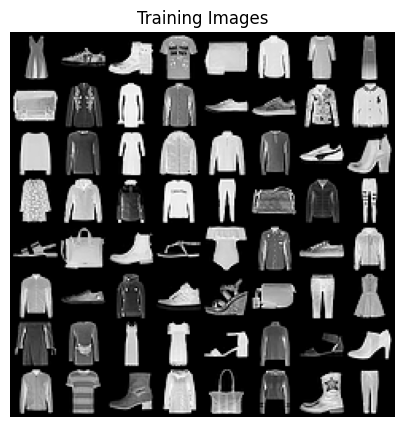

In [9]:
# Plot some training images
import numpy as np

real_batch = next(iter(data_loader))
plt.figure(figsize=(5, 5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# Create a directory to save the real image

sample_dir = 'samples_chk_LSGAN'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

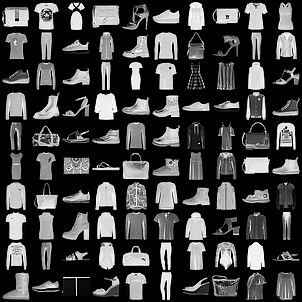

In [11]:
# Save real image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

# Show the real image - which is the first batch of 100 images
Image(os.path.join(sample_dir, 'real_images.png'))

**Step2. Train the GAN model to produce images in this new domain.**

Define the **Discriminator**

In [12]:
#Define a pretty simple Disriminator network which has:
# 1. Linear layer which takes in an input of image_size as 784 and hidden size 256
# 2. The output of the linear layer is passed through a ReLU activation function
# 3. The result of the activation function is then passed through a Linear layer which takes in 256 input and produces 256 outputs
# 4. This result is again passed through a leaky relu layer.
# 5. Finally the output is passed through a Linear layer and the result is passed through the sigmoid function.

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

Define the **Generator**

In [13]:
#Define a pretty simple Generator network which has:
# 1. Linear layer which takes in an input of image_size as 64 and hidden size 256
# 2. The output of the linear layer is passed through a ReLU activation function
# 3. The result of the activation function is then passed through a Linear layer which takes in 256 input and produces 256 outputs
# 4. This result is again passed through a leaky relu layer.
# 5. Finally the output is passed through a Linear layer and the result is passed through the tanh() function.

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

**Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.**

In [14]:
y = G(torch.randn(3, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

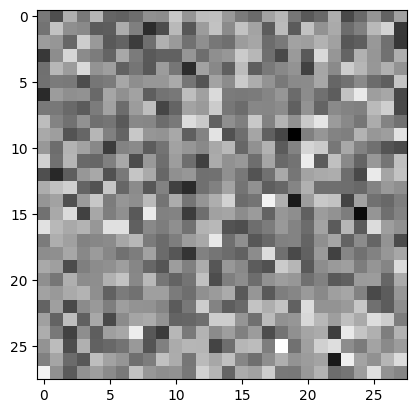

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');

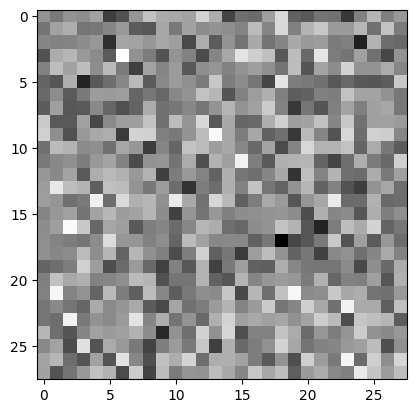

In [16]:
plt.imshow(gen_imgs[1], cmap='gray');

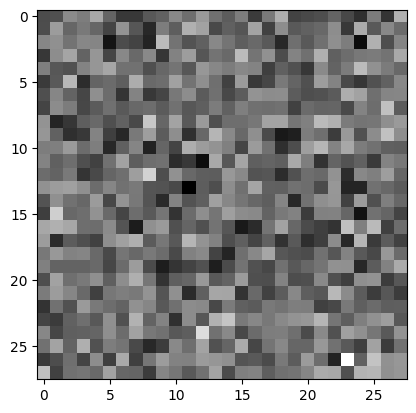

In [17]:
plt.imshow(gen_imgs[2], cmap='gray');

In [18]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [19]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

Training the Discriminator starts with defining the loss and optimizier. The Discriminator need to identify between real and fake images, it is binary classification and hence use the Binary class entropy for the loss calculation. Using the Adam optimizer to perform gradient descent.

The discriminator will class all images from the data_loader dataset which is the FASHIONMNIST dataset as real images and the images from Generator as fake images. We find the loss for the images from the MNIST dataset by setting the labels to be compared with in the loss function as 1 and vice versa for the images generated by the generator. After we have calculated the loss for both the real and fake set of images, we add the two losses as the net loss for the discriminator. You can also observe that only the gradients of the discriminator is being calculated and not that of the generator as in this piece of code we are only training the discriminator.

In [20]:
# Define the loss and optimizer

# Define MSE loss
criterion = nn.MSELoss()

# Optimizer for Discriminator
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [21]:
#Training the discriminator

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # So essentially, you use the given set of real images and feed it to the discriminator and train to understand the pattern of the real images.
    # Then, you generate a bunch of fake images and then feed them to the discriminator to train them to understand the pattern of the fake images.

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Training the Generator. A batch of images are generated by the Generator. These images are passed to the Discriminator with label 1 saying they are the real images. This will calculate how far the real images are from the fake ones, calculate the loss.

At the end of the function we see that the weights of the Generator are updated but the weights of the Discriminator stay the same.

In [22]:
# Optimizer for the Generator

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [23]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    # Assuming 'fake_images' is a tensor you've generated
    #fake_images = ... # Your code to generate or get fake images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    fake_fname = 'fake_images-{index:04d}-{timestamp}.png'.format(index=index, timestamp=timestamp)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [25]:
# Before training

save_fake_images(0)

Saving fake_images-0000-20240305_045739.png


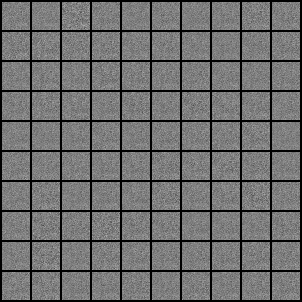

In [26]:
#save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000-20240305_045739.png'))

In [27]:
%%time

num_epochs = 20
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/20], Step [200/600], d_loss: 0.0073, g_loss: 0.9107, D(x): 0.98, D(G(z)): 0.07
Epoch [0/20], Step [400/600], d_loss: 0.0189, g_loss: 0.9400, D(x): 0.99, D(G(z)): 0.11
Epoch [0/20], Step [600/600], d_loss: 0.0005, g_loss: 0.9836, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0001-20240305_045832.png
Epoch [1/20], Step [200/600], d_loss: 0.0020, g_loss: 0.9670, D(x): 0.99, D(G(z)): 0.03
Epoch [1/20], Step [400/600], d_loss: 0.0334, g_loss: 0.9732, D(x): 0.94, D(G(z)): 0.01
Epoch [1/20], Step [600/600], d_loss: 0.0032, g_loss: 0.9674, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0002-20240305_045902.png
Epoch [2/20], Step [200/600], d_loss: 0.0113, g_loss: 0.9017, D(x): 0.99, D(G(z)): 0.09
Epoch [2/20], Step [400/600], d_loss: 0.0065, g_loss: 0.9801, D(x): 0.99, D(G(z)): 0.01
Epoch [2/20], Step [600/600], d_loss: 0.0013, g_loss: 0.9874, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0003-20240305_045931.png
Epoch [3/20], Step [200/600], d_loss: 0.0239, g_loss: 0.9682, D(x): 0.97, D(

Check some of the saved images created by the Generator

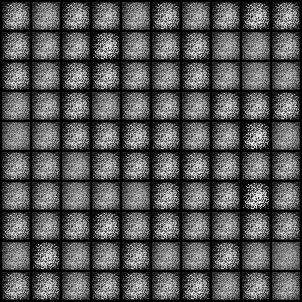

In [28]:
Image(os.path.join(sample_dir, 'fake_images-0001-20240305_045832.png'))

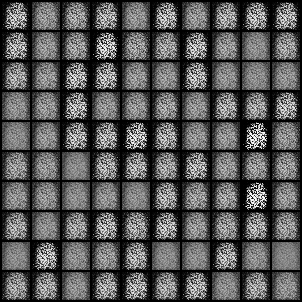

In [29]:
Image(os.path.join(sample_dir, 'fake_images-0002-20240305_045902.png'))

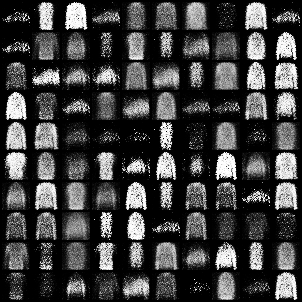

In [30]:
Image(os.path.join(sample_dir, 'fake_images-0014-20240305_050455.png'))

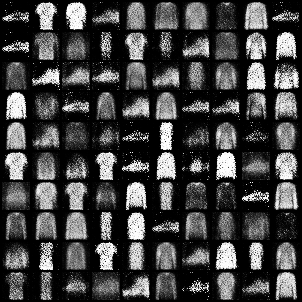

In [31]:
# Last image in epoch
Image(os.path.join(sample_dir, 'fake_images-0020-20240305_050749.png'))

View the losses and accuracies

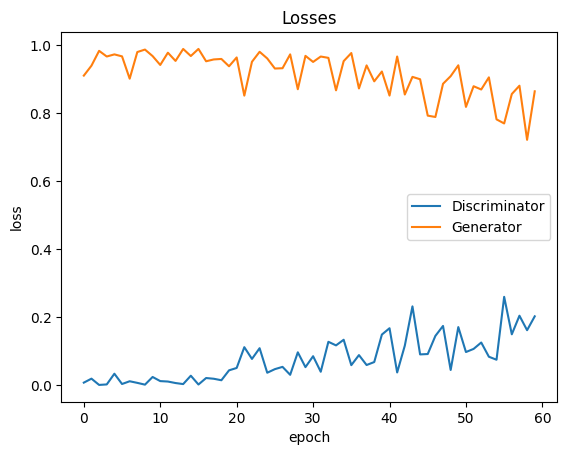

In [32]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

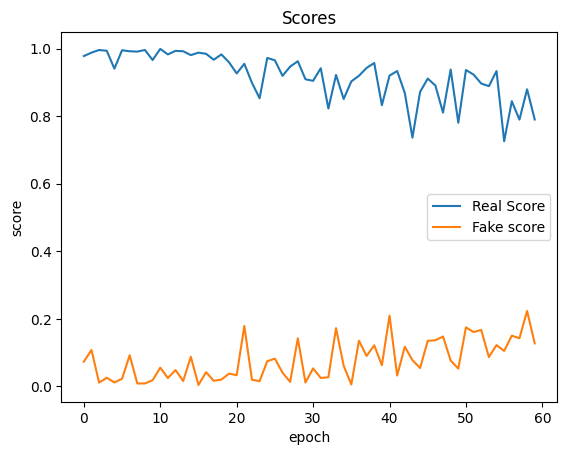

In [33]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

**Step4. Save the model weights in the folder to be used later.**

In [34]:
# Save checkpoint function saves the state dictionaries for model and optimizer
# Save the model checkpoints

# Define your checkpoint directory and prefix
checkpoint_dir = './training_checkpoints_LSGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Ensure the checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# To save a checkpoint
def save_checkpoint(epoch, genG, discriM, g_optimizer, d_optimizer, filename="checkpoint.pth.tar"):
    save_path = os.path.join(checkpoint_dir, f"{filename}_{epoch}")
    torch.save({
        'Generator': G.state_dict(),
        'Discriminator': D.state_dict(),
        'G_optimizer_state_dict': g_optimizer.state_dict(),
        'D_optimizer_state_dict': d_optimizer.state_dict(),
    }, save_path)
    print(f"Checkpoint saved to {save_path}")

In [35]:
torch.save(G.state_dict(), 'G_fashion_mnist.pth')
torch.save(D.state_dict(), 'D_fashion_mnist.pth')


In [36]:
# Set path to save the models

G.load_state_dict(torch.load('G_fashion_mnist.pth'))
D.load_state_dict(torch.load('D_fashion_mnist.pth'))


<All keys matched successfully>

Save the models

In [37]:
checkpoint = save_checkpoint(num_epochs, G, D, g_optimizer, d_optimizer)

Checkpoint saved to ./training_checkpoints_LSGAN/checkpoint.pth.tar_20


**Step5. Load the model using the saved weights.**

In [39]:
# To load a checkpoint, loads the state dictionaries for model and optimizer

def load_checkpoint(model_path, genG, discriM, genG_optimizer, discriM_optimizer):
    checkpoint = torch.load(model_path)
    genG.load_state_dict(checkpoint['Generator'])
    discriM.load_state_dict(checkpoint['Discriminator'])
    genG_optimizer.load_state_dict(checkpoint['G_optimizer_state_dict'])
    discriM_optimizer.load_state_dict(checkpoint['D_optimizer_state_dict'])
    print(f"Checkpoint loaded from {model_path}")

In [40]:
# Define the location of the model to load
checkpoint_dir = './training_checkpoints_LSGAN'
filename="checkpoint.pth.tar_20"
file_path = os.path.join(checkpoint_dir, filename)

load_model = load_checkpoint(file_path, G, D, g_optimizer, d_optimizer)

Checkpoint loaded from ./training_checkpoints_LSGAN/checkpoint.pth.tar_20


**Step 6: Re-train the GAN model to see if you can improve.**

In [41]:
%%time

num_epochs = 20
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/20], Step [200/600], d_loss: 0.1670, g_loss: 0.7267, D(x): 0.81, D(G(z)): 0.14
Epoch [0/20], Step [400/600], d_loss: 0.1918, g_loss: 0.8508, D(x): 0.77, D(G(z)): 0.12
Epoch [0/20], Step [600/600], d_loss: 0.2007, g_loss: 0.7895, D(x): 0.85, D(G(z)): 0.21
Saving fake_images-0001-20240305_051446.png
Epoch [1/20], Step [200/600], d_loss: 0.1388, g_loss: 0.7745, D(x): 0.84, D(G(z)): 0.12
Epoch [1/20], Step [400/600], d_loss: 0.1262, g_loss: 0.8233, D(x): 0.93, D(G(z)): 0.20
Epoch [1/20], Step [600/600], d_loss: 0.2213, g_loss: 0.6967, D(x): 0.83, D(G(z)): 0.22
Saving fake_images-0002-20240305_051515.png
Epoch [2/20], Step [200/600], d_loss: 0.1598, g_loss: 0.8675, D(x): 0.80, D(G(z)): 0.11
Epoch [2/20], Step [400/600], d_loss: 0.2477, g_loss: 0.7455, D(x): 0.77, D(G(z)): 0.19
Epoch [2/20], Step [600/600], d_loss: 0.1774, g_loss: 0.8263, D(x): 0.84, D(G(z)): 0.18
Saving fake_images-0003-20240305_051544.png
Epoch [3/20], Step [200/600], d_loss: 0.2348, g_loss: 0.7688, D(x): 0.79, D(

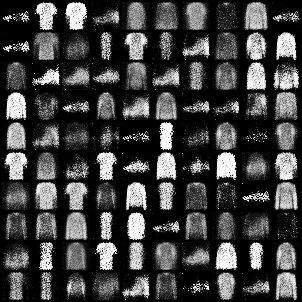

In [42]:
# Show images from the loaded model
Image(os.path.join(sample_dir, 'fake_images-0001-20240305_051446.png'))

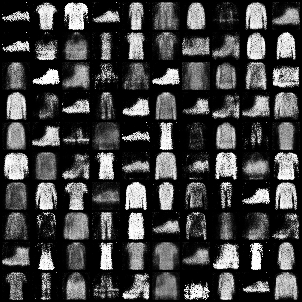

In [43]:
Image(os.path.join(sample_dir, 'fake_images-0020-20240305_052341.png'))

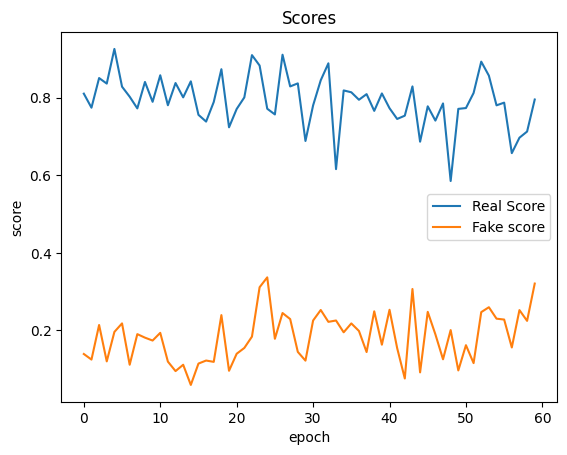

In [44]:
# Show plot of real and fake scores

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');


**Step 7: Save the model weights without using checkpoints.**

In [45]:
# specify a path to save models

save_directory = './saved_models'

# Check if the directory exists, and if not, create it
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save weights without check point
torch.save(G.state_dict, os.path.join(save_directory, 'G_weights.pth'))
torch.save(D.state_dict, os.path.join(save_directory, 'D_weights.pth'))

**Step 8: Load the model weights without using checkpoints.**

In [46]:
# Load the models again

genG = G.to(device)
discriM = D.to(device)

# Load generator and discriminator weights
genG_weights = torch.load(os.path.join(save_directory, 'G_weights.pth'))
discriM_weights = torch.load(os.path.join(save_directory, 'D_weights.pth'))

**Compare LS-GAN with GAN results**

1. GAN uses the binary cross entroy. LS-GAN uses the MSE.
2. On plotting the "Loss" graph, the LS-GAN start to overlap near around 250 epochs, while GAN is almost near around 400 epochs. I have submitted these results in another notebook. This notebook took 20 epochs into consideration and on extrapolation would look like the other notebook with 300 epochs.
3. The real and fake scores start to barely get close near 650 epochs, while LS-GAN is around near 400 epochs ,which I have submitted as another notebook. This notebook took 20 epochs into consideration and on extrapolation would look like the other notebook with 300 epochs.
4. GAN and LS-GAN took the same amount of time, around 3 hours for 300 epochs, which I have submitted as another notebook. This notebook took 20 epochs into consideration and on extrapolation would look like the other notebook with 300 epochs.
5. The images generated by GAN appear to be smoother than those by LS_GAN.
6. GANs require careful tuning and monitoring during training to ensure stability. On the other hand, LS-GANs are considered to be more stable during training and appear to converge faster.